# **Рекомендация тарифов**

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Цель проекта

Главной **целью** данного проекта стала разработка модели классификации с гиперпараметрами для оператора мобильной связи "Мегалайн" для подбора подходящих для клиентов тарифов ("Смарт" или "Ультра"), на основе данных об их пользовательском поведении. Модель поможет заказчику определить, каким пользователям следует перейти в другой тариф. 

# **Предоставленные заказчиком данные**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- *сalls* — количество звонков,
- *minutes* — суммарная длительность звонков в минутах,
- *messages* — количество sms-сообщений,
- *mb_used* — израсходованный интернет-трафик в Мб,
- *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**План реализации проекта:**  
- 

План выполнения проекта:  
1. Ознакомиться с файлами  
2. Произвести первичную обработку данных  
- Изменить тип данных в некоторых переменных
- Проверить на дубликаты
3. Разбить данные на выборки - обучающую, валидационную и тестовую  
4. Исследовать модели  
- отделить целевой признак от других в каждой выборке. 
- подобрать нужные гиперпараметры для каждой рассмотренной модели
- сравнить модели по метрикам качества
5. Протестировать на тестовой выборке
6. Сделать вывод

## Исследование предоставленных данных

На данном этапе я посмотрю, что из себя представляют данные, чтобы затем конкретизовать задачи. 

Прежде, чем начать исследование, следует импортировать необходимые библиотеки

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
from time import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

!pip install catboost
from catboost import CatBoostClassifier

Далее я введу значение константы для дальнейшего выполнения проекта

In [2]:
SEED = 280823

Предоставленный заказчиком датасет следует открыть универсальным способом.

In [3]:
way_1 = '/Users/anastasiaklubkova/Downloads/users_behavior.csv'
way_2 = '/datasets/users_behavior.csv'

In [4]:
if os.path.exists(way_1):
    data = pd.read_csv(way_1)
    print('Открыто локально')
elif os.path.exists(way_2):
    data = pd.read_csv(way_2)
    print('Открыто через ЯП')
else:
    print('Что-то пошло не так')

Открыто локально


In [5]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Вывод:** В данных отсутствуют пропуски и нет необходимости корректировать названия столбцов. Также можно наблюдать, что следует изменить тип столбцов "calls" и "messages", поскольку это натуральные числа, а не вещественные.

In [7]:
data.duplicated().sum()

0

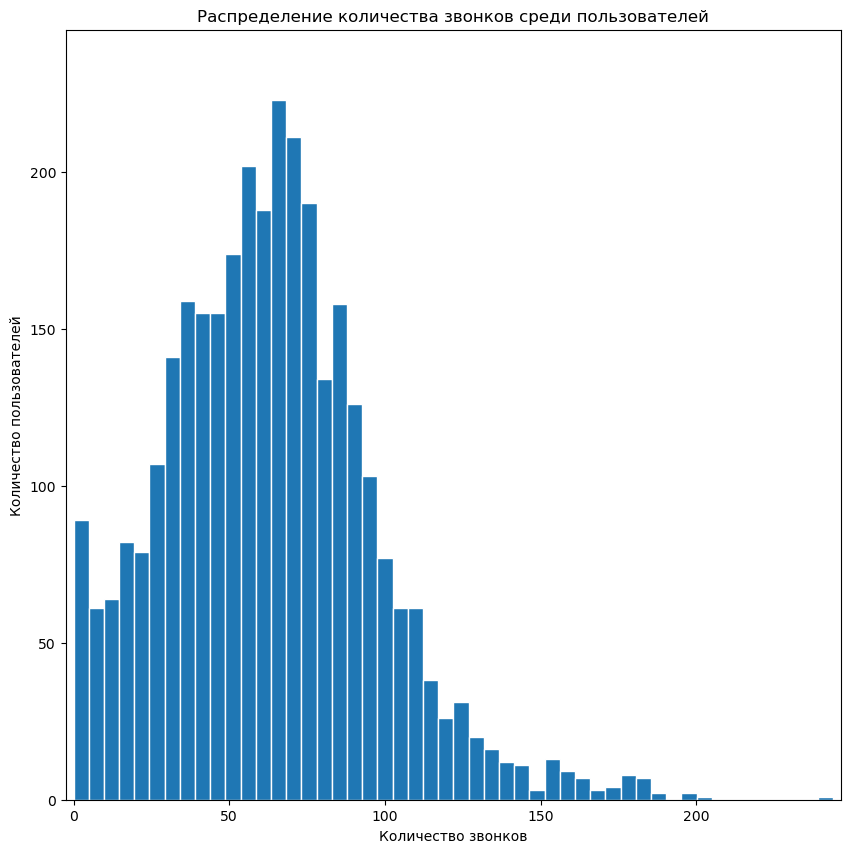

In [8]:
plt.figure(figsize=(10, 10))
values, bins, bars = plt.hist(data['calls'], bins=50, edgecolor='white')
plt.xlabel('Количество звонков')
plt.ylabel("Количество пользователей")
plt.title('Распределение количества звонков среди пользователей')
plt.margins(x=0.01, y=0.1)
plt.show()

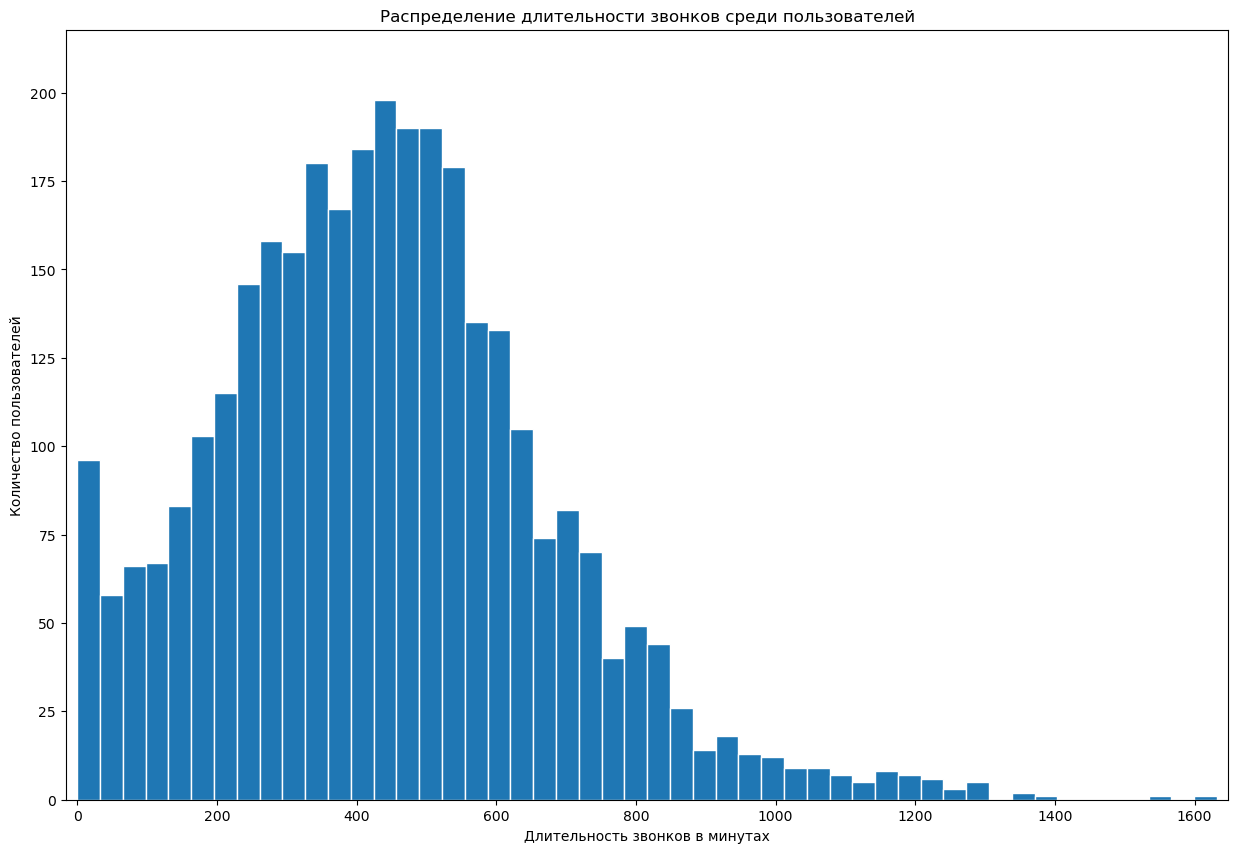

In [9]:
plt.figure(figsize=(15, 10))
values, bins, bars = plt.hist(data['minutes'], bins=50, edgecolor='white')
plt.xlabel('Длительность звонков в минутах')
plt.ylabel("Количество пользователей")
plt.title('Распределение длительности звонков среди пользователей')
plt.margins(x=0.01, y=0.1)
plt.show()

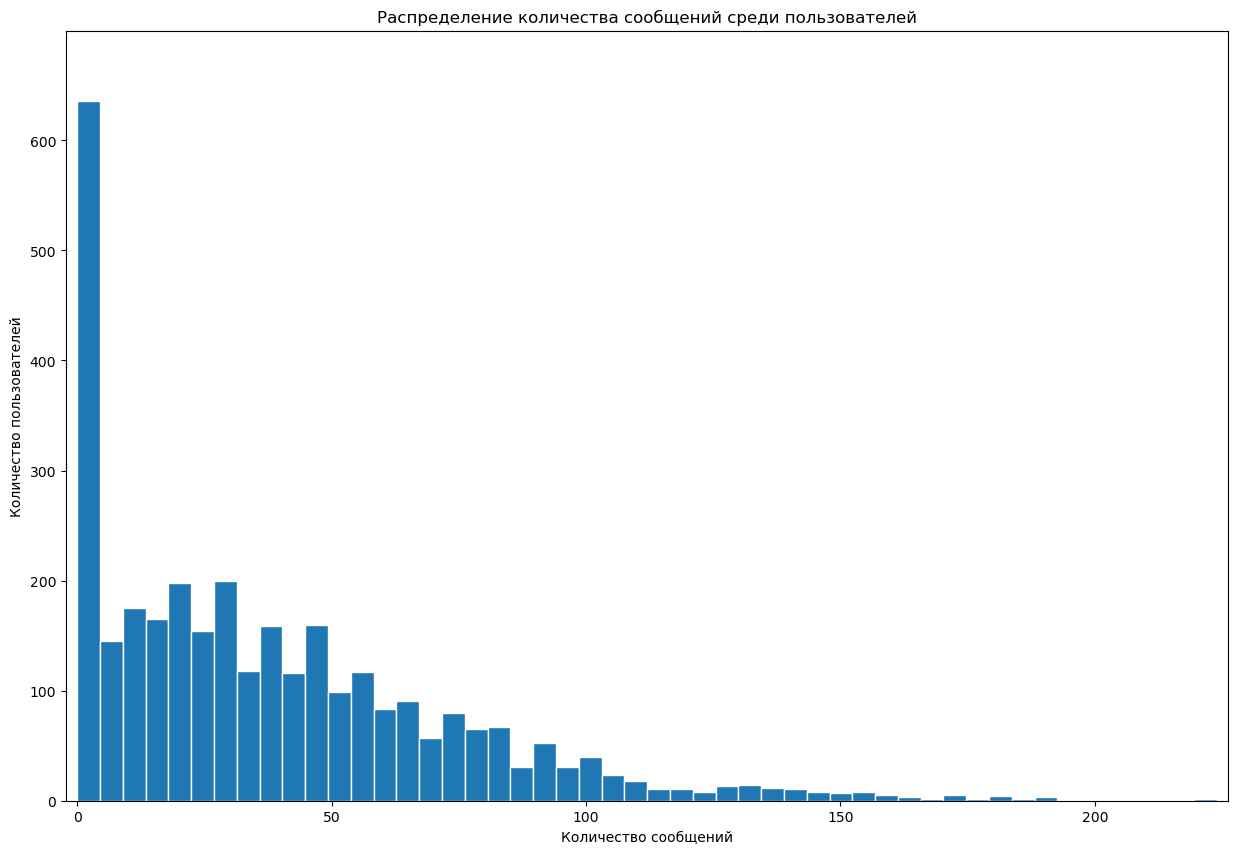

In [10]:
plt.figure(figsize=(15, 10))
values, bins, bars = plt.hist(data['messages'], bins=50, edgecolor='white')
plt.xlabel('Количество сообщений')
plt.ylabel("Количество пользователей")
plt.title('Распределение количества сообщений среди пользователей')
plt.margins(x=0.01, y=0.1)
plt.show()

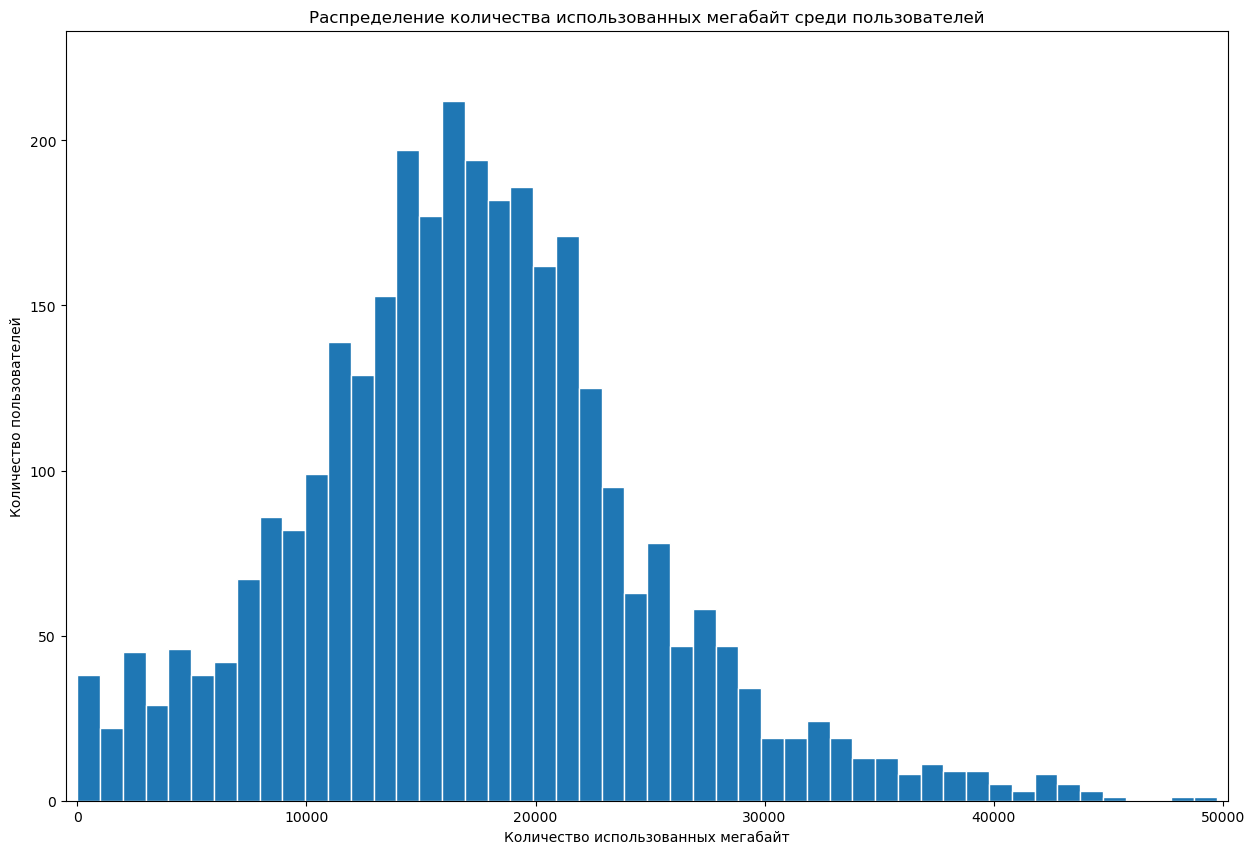

In [11]:
plt.figure(figsize=(15, 10))
values, bins, bars = plt.hist(data['mb_used'], bins=50, edgecolor='white')
plt.xlabel('Количество использованных мегабайт')
plt.ylabel("Количество пользователей")
plt.title('Распределение количества использованных мегабайт среди пользователей')
plt.margins(x=0.01, y=0.1)
plt.show()

In [12]:
data[['calls', 'minutes', 'messages', 'mb_used']].describe()

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836
std,33.236368,234.569872,36.148326,7570.968246
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500
50%,62.000000,430.600000,30.000000,16943.235000
75%,82.000000,571.927500,57.000000,21424.700000
max,244.000000,1632.060000,224.000000,49745.730000


**Вывод по данному разделу:**  
На основании первичного анализа предоставленного датасета, можно заключить, что:  
- Пропуски отсутствуют
- Дубликаты отсутствуют
- Названия признаков соответсвуют правилам
- Следует изменить тип даннных признаков "calls" и "messages"

Также можно предположить, опираясь на распределение данных, что пользователи чаще пользуются предоставленными мегабайтами, чем звонками и смс-сообщеними, поскольку в распределении двух последних услуг один из пиков находится на нулевом значении (явно выражен в распределении количества отправленных сообщений). Нулевые аномалиии следует исследовать. 

##  Предобработка данных

Стоит начать с изменения типа данных

In [13]:
data['calls'] = data['calls'].astype('int')

In [14]:
data['messages'] = data['messages'].astype('int')

In [15]:
data.dtypes

calls         int64
minutes     float64
messages      int64
mb_used     float64
is_ultra      int64
dtype: object

##  Исследовательский анализ данных

На данном этапе я бы хотела рассмотреть "портрет пользователя" разных тарифов. Если будут обнаружены закономерности, то заказчик сможет сделать предварительную рекомендацию для новых пользователей. 

Для начала следует проверить нулевые аномалии равенства количества звонков и их длительность.

In [16]:
data.loc[(data['calls'] != 0) & (data['minutes'] == 0)]

,calls,minutes,messages,mb_used,is_ultra


In [17]:
data.loc[(data['calls'] == 0) & (data['minutes'] != 0)]

,calls,minutes,messages,mb_used,is_ultra


Затем стоит разбить предоставленный датасет по целевому признаку - по тарифам. 

In [18]:
data_ultra = data[data['is_ultra']==1]
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 3 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     985 non-null    int64  
 1   minutes   985 non-null    float64
 2   messages  985 non-null    int64  
 3   mb_used   985 non-null    float64
 4   is_ultra  985 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 46.2 KB


In [19]:
data_smart = data[data['is_ultra']==0]
data_smart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     2229 non-null   int64  
 1   minutes   2229 non-null   float64
 2   messages  2229 non-null   int64  
 3   mb_used   2229 non-null   float64
 4   is_ultra  2229 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 104.5 KB


Теперь следует рассмотреть разницу между потреблением услуг оператора у пользователей разных тарифов.

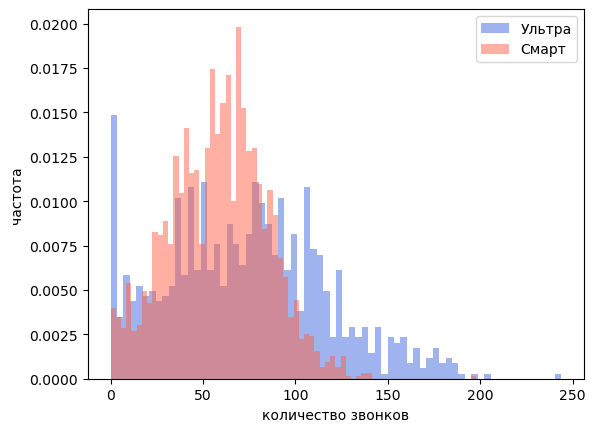

<Figure size 600x900 with 0 Axes>

In [20]:
plt.hist(data_ultra['calls'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='Ультра')
plt.hist(data_smart['calls'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='Смарт')

plt.title = 'Разница использования услуги звонков на тарифах "Ультра" и "Смарт"'
plt.xlabel('количество звонков')
plt.ylabel('частота')
plt.legend()
plt.figure(figsize=(6, 9))
plt.show()

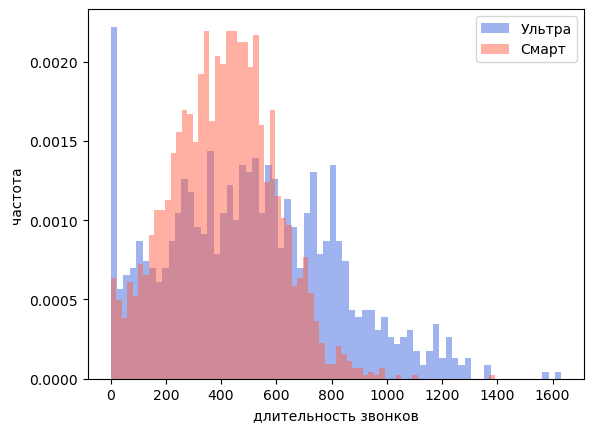

<Figure size 600x900 with 0 Axes>

In [21]:
plt.hist(data_ultra['minutes'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='Ультра')
plt.hist(data_smart['minutes'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='Смарт')

plt.title = 'Разница использования минут звонков на тарифах "Ультра" и "Смарт"'
plt.xlabel('длительность звонков')
plt.ylabel('частота')
plt.legend()
plt.figure(figsize=(6, 9))
plt.show()

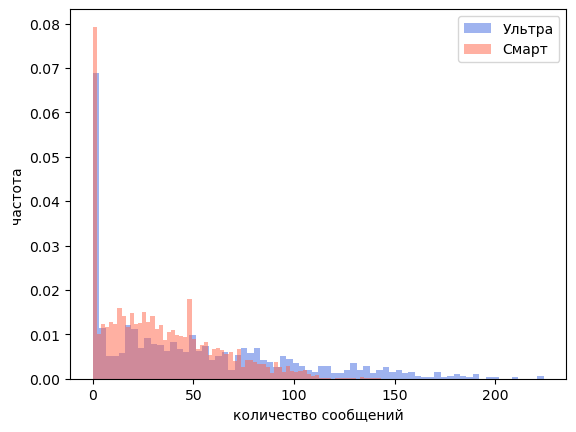

<Figure size 600x900 with 0 Axes>

In [22]:
plt.hist(data_ultra['messages'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='Ультра')
plt.hist(data_smart['messages'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='Смарт')

plt.title = 'Разница использования услуги смс-сообщений на тарифах "Ультра" и "Смарт"'
plt.xlabel('количество сообщений')
plt.ylabel('частота')
plt.legend()
plt.figure(figsize=(6, 9))
plt.show()

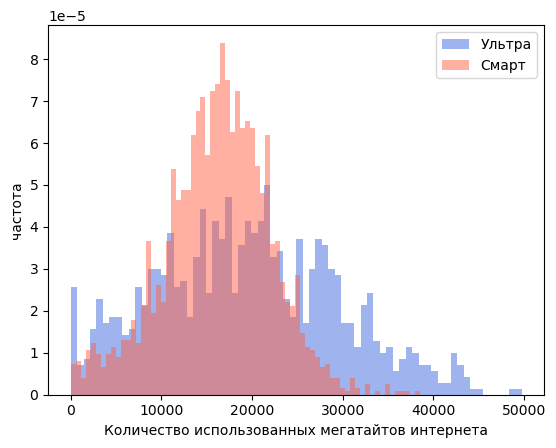

<Figure size 600x900 with 0 Axes>

In [23]:
plt.hist(data_ultra['mb_used'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='Ультра')
plt.hist(data_smart['mb_used'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='Смарт')

plt.title = 'Разница использования мегабайт интернета на тарифах "Ультра" и "Смарт"'
plt.xlabel('Количество использованных мегатайтов интернета')
plt.ylabel('частота')
plt.legend()
plt.figure(figsize=(6, 9))
plt.show()

**Вывод:**  
Пользователи тарифа "Ультра":  

- В среднем звонят столько же, сколько и пользователи из другого тарифа, однако, можно заключить, что пользователи этого тарифа звонили большее количество раз.
- В данном тарифе больше тех, кто ни разу не звонил.
- Закономерно, что общая длительность звонков также больше, чем у пользователей тарифа "Смарт".
- Также было отправлено большее количество сообщений
- Среднее количество потраченных мегабайтов интернета у пользователей тарифа похоже, однако, пользователи тарифа "Ультра" потратили больше

Пользователи тарифа "Смарт":  
- Пользователи данного тарифа в целом тратили большее количество единиц услуг
- А также среди них меньше пользователей, которые бы не пользовались услугой

Можно заключить, что данная разница обусловлена тем, что сами тарифы несут в себе ограничение, вполне вероятно, что тариф "Смарт" включает меньшее количество доступных пользователям минут звонков, сообщений и мегабайт интернета. 

Далее следует изучить количественные признаки на предмет мультиколлениарности, а также корреляции с целевым признаком.

<Axes: >

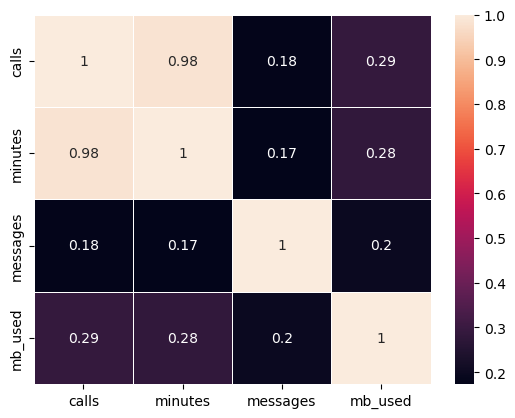

In [24]:
sns.heatmap(data.drop('is_ultra', axis=1).corr(), linewidths=.5, annot=True)

Признак "calls" и "minutes" связаны прямым образом, однако, в условиях дефицита признаков не стоит удалять признаки
Отдельно проверю корреляцию с целевым признаком количественных переменных

In [25]:
data['calls'].corr(data['is_ultra'])

0.20712155898607568

In [26]:
data['minutes'].corr(data['is_ultra'])

0.2069546381216952

In [27]:
data['messages'].corr(data['is_ultra'])

0.2038298385355364

In [28]:
data['mb_used'].corr(data['is_ultra'])

0.19856764561974266

Значимых корреляций с целевым признаком не обнаружено, решение не удалять признаки остается в силе.

#  Подготовка признаков и построение моделей

На данном шаге я собираюсь разбить исходные данные на обучающую, валидационную и тестовую выборку (так как у нас нет скрытой тестовой выборки вне исходных данных) для построения модели. Процентное соотношение данных в выборках к исходным следующее: 60, 20, 20 (соответственно). 

Прежде, чем преобразовывать данные, следует создать их копию

In [29]:
data_copy = data
data_copy.shape == data.shape

True

In [30]:
data_copy = data_copy.reset_index(drop= True)
data_copy.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


Далее я разделю выборки согласно условию проекта

In [31]:
data_train, data_test = train_test_split(data_copy, test_size=0.25, random_state=SEED)

In [32]:
features_train = data_train.drop(columns = ['is_ultra'])
target_train = data_train['is_ultra']

features_test = data_test.drop(columns = ['is_ultra'])
target_test = data_test['is_ultra']

Теперь следует проверить, в каком реальном соотношении разделились исходные данные по выборкам.

In [33]:
data_train.shape[0]/len(data)

0.7498444306160548

In [34]:
data_test.shape[0]/len(data)

0.25015556938394523

Далее следует преобразовать численные признаки, поскольку в дальнейшем будут использоваться линейные модели, а также масштаб признаков отличается друг от друга

In [35]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

print(features_train.shape)
print(features_test.shape)

(2410, 4)
(804, 4)


На данном этапе я проанализирую качества разных моделей классификации, чтобы выявить лучшую. К моделям классификации относятся DecisionTreeClassifier, RandomForestClassifier, LogisticRegression и CatBoostClassifier.

В качестве целевого признака выступает тариф клиента ('is_ultra').

In [36]:
classifiers = [DecisionTreeClassifier(random_state=SEED), 
               RandomForestClassifier(random_state=SEED),
               LogisticRegression(random_state=SEED),
               CatBoostClassifier(random_state=SEED, verbose=False)]

In [37]:
head = 10
for model in classifiers[:head]:
    start = time()
    model.fit(features_train, target_train)
    train_time = time() - start
    start = time()
    pred_train = model.predict(features_train)
    scores = cross_val_score(estimator = model, X=features_train, y=target_train, scoring='accuracy')
    final_score = sum(scores) / len(scores)
    predict_time = time()-start
    print(model)
    print("\tВремя обучения: %0.3fs" % train_time)
    print("\tВремя предсказания+оценка: %0.3fs" % predict_time)
    print('Средняя оценка качества модели:', final_score)
    print()

DecisionTreeClassifier(random_state=280823)
	Время обучения: 0.015s
	Время предсказания+оценка: 0.044s
Средняя оценка качества модели: 0.716182572614108

RandomForestClassifier(random_state=280823)
	Время обучения: 0.294s
	Время предсказания+оценка: 1.228s
Средняя оценка качества модели: 0.8016597510373444

LogisticRegression(random_state=280823)
	Время обучения: 0.063s
	Время предсказания+оценка: 0.013s
Средняя оценка качества модели: 0.7473029045643154

	Время обучения: 1.370s
	Время предсказания+оценка: 5.369s
Средняя оценка качества модели: 0.8099585062240664



По результатам предварительного анализа качества моделей с помощью метрики "accuracy", следует обратить внимание на несколько моделей - CatBoostClassifier() и RandomForestClassifier() с показателями accuracy 80% и 81% соответственно.

Далее будет проиведен подбор гиперпараметров для каждой выбранной модели. 

In [38]:
parameters_1 = {'depth' : (range(4, 5, 6)),
                'iterations': (range(50, 200, 50)),
                'learning_rate' : [0.05, 0.5, 0.05],
                'random_state': [SEED]
             }

In [39]:
%%time
grid = GridSearchCV(CatBoostClassifier(),parameters_1, scoring='accuracy', cv = 5, n_jobs=-1)

model = grid.fit(features_train, target_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

0:	learn: 0.6774208	total: 55.9ms	remaining: 2.74s
1:	learn: 0.6624951	total: 56.5ms	remaining: 1.35s
2:	learn: 0.6475969	total: 57ms	remaining: 892ms
3:	learn: 0.6346877	total: 57.3ms	remaining: 660ms
4:	learn: 0.6223105	total: 58.1ms	remaining: 523ms
5:	learn: 0.6117750	total: 58.4ms	remaining: 428ms
6:	learn: 0.6017452	total: 58.8ms	remaining: 361ms
7:	learn: 0.5930336	total: 59.3ms	remaining: 311ms
0:	learn: 0.6782288	total: 59.2ms	remaining: 2.9s
1:	learn: 0.6647044	total: 59.7ms	remaining: 1.43s
8:	learn: 0.5841681	total: 59.9ms	remaining: 273ms
2:	learn: 0.6501820	total: 60.1ms	remaining: 942ms
3:	learn: 0.6390786	total: 60.4ms	remaining: 695ms
9:	learn: 0.5767030	total: 60.2ms	remaining: 241ms
10:	learn: 0.5695518	total: 60.4ms	remaining: 214ms
4:	learn: 0.6272094	total: 60.9ms	remaining: 548ms
11:	learn: 0.5629682	total: 60.7ms	remaining: 192ms
12:	learn: 0.5567744	total: 61.1ms	remaining: 174ms
5:	learn: 0.6169142	total: 61.4ms	remaining: 450ms
13:	learn: 0.5500916	total: 61.

In [40]:
parameters_2 = {'n_estimators' : (range(10, 100, 10)),
                'max_depth' : (range(1, 7)),
                'random_state': [SEED]
             }

In [41]:
%%time
grid = GridSearchCV(RandomForestClassifier(),parameters_2, scoring='accuracy', cv = 5, n_jobs=-1)

model = grid.fit(features_train, target_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

{'max_depth': 6, 'n_estimators': 10, 'random_state': 280823} 

0.8103734439834025 

CPU times: user 164 ms, sys: 35.4 ms, total: 200 ms
Wall time: 3.95 s


In [42]:
parameters_3 = {'min_samples_split' : (range(2, 100)),
                'max_depth' : (range(1, 20)),
                'random_state': [SEED]
             }

In [43]:
%%time
grid = GridSearchCV(DecisionTreeClassifier(),parameters_3, scoring='accuracy', cv = 5, n_jobs=-1)

model = grid.fit(features_train, target_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

{'max_depth': 9, 'min_samples_split': 98, 'random_state': 280823} 

0.8008298755186722 

CPU times: user 1.18 s, sys: 75.1 ms, total: 1.26 s
Wall time: 8.05 s


In [44]:
%time
model = LogisticRegression(random_state=SEED).fit(features_train, target_train)
score = cross_val_score(estimator = model, X=features_train, y=target_train, scoring='accuracy')
final_score = sum(score) / len(score)
final_score

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.15 μs


0.7473029045643154

В более ранней версии данного проекта мной был разработан следующий шаблон подбора оптимальных гиперпараметров:  

In [45]:
'''
criterion_type = ['gini', 'entropy']   
splitter_type = ['best', 'random']   

best_model = None   
best_depth = 0   
best_accouracy = 0   
best_precision = 0   
best_recall = 0   

for crit in criterion_type:   
    for splt in splitter_type:
        for split in range(2, 100, 2):
            for leaf in (1, 100):
                for depth in range(1, 20):
                    model = DecisionTreeClassifier(random_state=12345, max_depth = depth, criterion = crit, splitter = splt, min_samples_split = split, min_samples_leaf = leaf)

                    model.fit(features_train, target_train)

                    predictions_train = model.predict(features_train)
                    predictions_valid = model.predict(features_val)

                    accuracy_score_train = accuracy_score(target_train, predictions_train)
                    accuracy_score_valid = accuracy_score(target_val, predictions_valid)

                    precision_score_train = precision_score(target_train, predictions_train)
                    precision_score_valid = precision_score(target_val, predictions_valid)

                    recall_score_train = recall_score(target_train, predictions_train)
                    recall_score_valid = recall_score(target_val, predictions_valid)

                    if (accuracy_score_valid > accuracy_score_train) and (accuracy_score_valid > best_accouracy):
                        best_accouracy = accuracy_score_valid
                        best_model = model
                        best_depth = depth
                        best_leaf = leaf
                        best_split = split
                        best_splitter = splt
                        best_crit = crit
                    if accuracy_score_valid == best_accouracy:
                        best_precision = precision_score_valid
                        best_recall = recall_score_valid 
print(f'Лучшая точность: {best_precision}')   
print(f'Лучшая полнота: {best_recall}')   
print(f'')   
print(f'max_depth: {best_depth}')   
print(f'criterion: {best_crit}')   
print(f'splitter: {best_splitter}')   
print(f'min_samples_split: {best_split}')   
print(f'min_samples_leaf: {best_leaf}')   
import warnings   

warnings.filterwarnings("ignore") 
'''

'\ncriterion_type = [\'gini\', \'entropy\']   \nsplitter_type = [\'best\', \'random\']   \n\nbest_model = None   \nbest_depth = 0   \nbest_accouracy = 0   \nbest_precision = 0   \nbest_recall = 0   \n\nfor crit in criterion_type:   \n    for splt in splitter_type:\n        for split in range(2, 100, 2):\n            for leaf in (1, 100):\n                for depth in range(1, 20):\n                    model = DecisionTreeClassifier(random_state=12345, max_depth = depth, criterion = crit, splitter = splt, min_samples_split = split, min_samples_leaf = leaf)\n\n                    model.fit(features_train, target_train)\n\n                    predictions_train = model.predict(features_train)\n                    predictions_valid = model.predict(features_val)\n\n                    accuracy_score_train = accuracy_score(target_train, predictions_train)\n                    accuracy_score_valid = accuracy_score(target_val, predictions_valid)\n\n                    precision_score_train = pr

Аналогичным способом были проанализированы и гиперепараметры других моделей, однако, метод GridSearchCV подобрал лучшие гиперпарметры с более высоким показателем качества моделей (кроме того, менее ресурсозатратным способом)

Таким образом, каждая из моделей преодолела порог заказчика в значении accuracy больше 0.75 . Однако, модель классификации Случайного леса (RandomForestClassifier) продемонстрировала более высокие показатели - 0.8103734439834025 при подобранных гиперпараметрах {'max_depth': 6, 'n_estimators': 10, 'random_state': 280823}. Следовательно, именно эту модель и стоит протестировать на тестовой выборке. 

### Тестирование модели

In [46]:
model = RandomForestClassifier(random_state= SEED, max_depth= 6, n_estimators=10, criterion='gini')
model.fit(features_train, target_train)

predictions_test = model.predict(features_test)

print('Качество модели на тестовой выборке', accuracy_score(target_test, predictions_test))
print('Точность ответов на тестовой выборке', precision_score(target_test, predictions_test))
print('Полнота модели на тестовой выборке', recall_score(target_test, predictions_test))

Качество модели на тестовой выборке 0.8009950248756219
Точность ответов на тестовой выборке 0.7612903225806451
Полнота модели на тестовой выборке 0.4896265560165975


In [48]:
preds_proba = model.predict_proba(features_test)

In [50]:
pred = np.argmax(preds_proba, axis=1)

Text(50.722222222222214, 0.5, 'True')

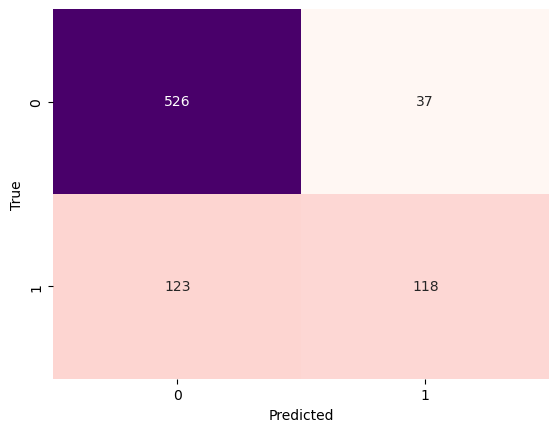

In [53]:
matrix_table = sns.heatmap(confusion_matrix(target_test, pred), annot=True, fmt='d', cmap="RdPu", cbar=False)
matrix_table.set_xlabel('Predicted')
matrix_table.set_ylabel('True')

Как можно заметить, модель чаще всего предсказывала тариф "Смарт" как подходящий для пользователя, однако, поскольку в предоставленных данных дисбаланс классов скошен в сторону этого же тарифа - модель чаще предсказывала верно. Также стоит обратить внимание, что модель случайного леса "рекомендовала" тариф "Смарт" пользователям тарифа "Ультра" чаще, чем тариф "Ультра" пользователям этого тарифа. Заказчику стоит обратить на это внимание (поведение модели основано на "подборе" оптимального тарифа на основании поведения пользователя (признаков датасета), поэтому нельзя сказать, что модель склонна к одному типу предсказания или "ошибается").

# Финальный отчет по проекту

Целью проекта являлась разработка модели классификации с подобранными гиперпараметрами для оператора мобильной связи "Мегалайн" для подбора подходящих для клиентов тарифов на основе поведения пользователей.

В ходе проекта были выделены следующие основные шаги, что соответствует изначально разработанному плану:  
1. Первичное знакомство с данными
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка признаков
5. Построение моделей
6. Тестирование лучшей модели

В ходе выполнения проекта были подготовлены признаки - изменены типы данных у нескольких из них ("calls" и "messages"), а также проведено масштабирование всех признаков.

По итогам первичного обучения моделей классификации DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, CatBoostClassifier - модели CatBoostClassifier и RandomForestClassifier показали лучшие результаты. По итогам обучения с подбором гиперпараметров была выбрана модель RandomForestClassifier с показателем качества accuracy 0.8103734439834025 при гиперпараметрах: {'max_depth': 6, 'n_estimators': 10, 'random_state': 280823}.

Данная модель была разработана не для предсказания класса целевого признака, а для определения оптимального класса на основе признаков. Анализ матрицы ошибок покзаал, что данная модель чаще рекомендует перенести пользователей в архивный тариф "Смарт", чем в тариф "Ультра". 